In [96]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from src.utils import is_divisible_by, assert_is_positive
from tqdm import tqdm
from scipy.linalg import lu_factor, lu_solve

In [125]:
v = 1
beta = 4
dy = 0.05
# dy = 0.001
# dy = 0.2
dx = 0.02 # tau
theta = 3/4
# theta = 1/2
# theta = 1/4
# x_lst = dx * np.array([0, 5, 10, 15, 20, 25]) #FIXME: type
# x_lst = dx * np.array([0, 5, 10, 15, 20, 25, 100]) #FIXME: type
# x_lst = np.array([0, 0.01, 0.05, 0.1, 0.5, 10]) #FIXME: type
# x_lst = np.array([0, 0.02, 0.06, 0.1, 0.5]) #FIXME: type
# x_lst = np.array([0, 0.1])
x_lst = 10 ** np.arange(2)
# x_lst = np.concatenate((np.array([0]), x_lst))
# np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

100%|██████████| 500/500 [00:00<00:00, 12499.71it/s]


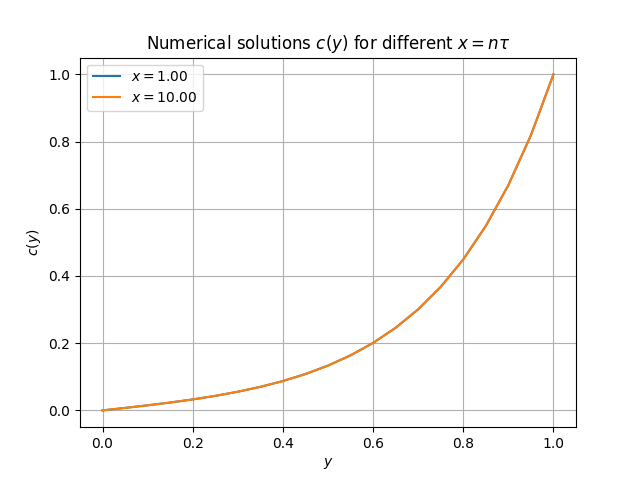

In [126]:
%matplotlib widget
plt.clf()

# Verify constants
assert_is_positive(v, 'v')
assert_is_positive(dy, 'dy')
assert is_divisible_by(1, dy), 'dy must divide 1.'
assert_is_positive(dx, 'dx')
assert 0 <= theta <= 1
assert all(is_divisible_by(x, dx) for x in x_lst), 'All x values must be divisible by dx.'
assert sorted(x_lst)[0] >= 0, 'All x values must be nonnegative.'

N = int(1 / dy) - 1
num_steps = int(sorted(x_lst)[-1] / dx)
y = np.linspace(0, 1, N + 2, dtype=np.float64) #FIXME: dtype?

def create_matrix_A(*, n: int = N, v: float = v, dy: float = dy, beta: float = beta):
    factor1 = -1 / (v * (dy**2))
    factor2 = -beta**2 / v

    main_diag = 2 * np.ones(n + 1)
    off_diag = -1 * np.ones(n)
    
    matrix1 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
    matrix2 = np.eye(n + 1)

    A = factor1 * matrix1 + factor2 * matrix2
    A[0, 1] = -2 # Neumann boundary condition at y=0
    return A

def create_r(*, n: int = N):
    r = np.zeros(n + 1) # r is a constant as it does not depend on x


    # r[0] = 0.1 / dy**2 # FIXME:
    #TODO: klopt dit?
    r[-1] = 1 / dy**2 # Dirichlet boundary condition at y=1
    return r

# FIXME: moet dit een functie zijn?
def create_u_0(*, n: int = N):
    '''
    Creates an initial concentration array `u_0` for x=0 as defined by the 
    Dirichlet boundary condition at x=0.

    The array `u_0` represents the concentration values at x=0 as a function of y.
    It includes the concentrations at y_0, y_1, ..., y_n but omits y_{n+1}.

    So, `u_0` = [c(0, y_0), c(0, y_1), ..., c(0, y_n)].
    '''
    return np.zeros(n + 1)

A = create_matrix_A()
r = create_r()

def theta_method(
    *,
    u_n: NDArray[np.float64],
    A: NDArray[np.float64] = A, # FIXME: mutable default argument
    r: NDArray[np.float64] = r,
    dx: float = dx,
    theta: float = theta
) -> NDArray[np.float64]:
    I = np.eye(A.shape[0])
    matrix = I - theta * dx * A
    b = u_n + dx * (1 - theta) * (A @ u_n + r) + dx * theta * r
    # print(b)
    u_next = np.linalg.solve(matrix, b)
    # print(u_next)
    return u_next

I = np.eye(N + 1)
matrix = I - theta * dx * A
lu, piv = lu_factor(matrix)
def theta_method_fast(
    *,
    u_n: NDArray[np.float64],
    A: NDArray[np.float64] = A,
    r: NDArray[np.float64] = r,
    dx: float = dx,
    theta: float = theta
) -> NDArray[np.float64]:
    b = u_n + dx * (1 - theta) * (A @ u_n + r) + dx * theta * r
    # print(b)
    u_next = lu_solve((lu, piv), b)
    # print(u_next)
    return u_next

# # FIXME: type
# u = np.empty(
#     shape=num_steps + 1, # +1 to include u_0
#     dtype=[('x', np.float64), ('c_y', np.float64, (N + 2,))]
# )
# u_0_numerical = create_u_0()
# u_0_full = np.append(u_0_numerical, 1) # Append 1 to include c(0, 1) = 1 Dirichlet boundary condition
# u[0] = (0, u_0_full)
# c_y_numerical = u_0_numerical

# for n in tqdm(range(num_steps)):
#     x = (n + 1) * dx
#     c_y_numerical = theta_method_fast(u_n=c_y_numerical)
#     c_y_full = np.append(c_y_numerical, 1)
#     u[n + 1] = (x, c_y_full)



# FIXME: type
u = np.empty(
    shape=0,
    dtype=[('x', np.float64), ('c_y', np.float64, (N + 2,))]
)
def append_u(x: float, c_y: NDArray[np.float64]) -> None:
    global u
    new_entry = np.array([(x, c_y)], dtype=u.dtype)
    u = np.append(u, new_entry)
u_0_numerical = create_u_0()
u_0_full = np.append(u_0_numerical, 1) # Append 1 to include c(0, 1) = 1 Dirichlet boundary condition
if 0 in x_lst:
    append_u(0, u_0_full)
c_y_numerical = u_0_numerical

for n in tqdm(range(num_steps)):
    x = (n + 1) * dx
    c_y_numerical = theta_method_fast(u_n=c_y_numerical)
    if x in x_lst:
        c_y_full = np.append(c_y_numerical, 1)
        append_u(x, c_y_full)

for x in x_lst:
    c_y = u[u['x'] == x]['c_y'][0]
    plt.plot(y, c_y, label=f'$x = {x:.2f}$')
plt.xlabel('$y$')
plt.ylabel('$c(y)$')
plt.title('Numerical solutions $c(y)$ for different $x = n \\tau$')
plt.legend()
plt.grid(True)
plt.show()

# TODO: wrm is het 0 bij y = 0
# TODO: geef gwn de plot waarop je moet plotten

<function matplotlib.pyplot.show(block=None)>

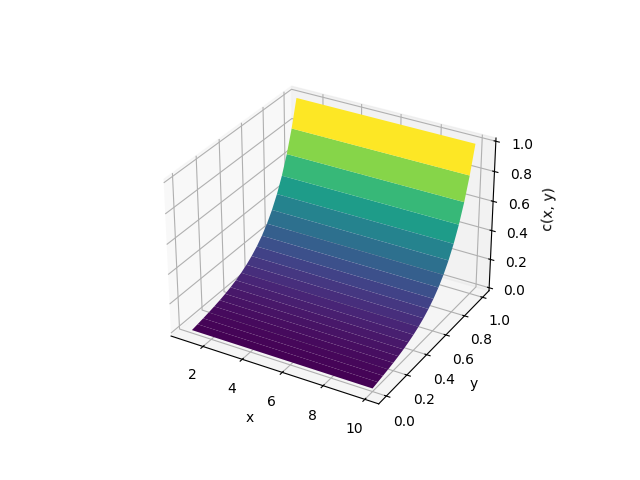

In [127]:
# X, Y = np.meshgrid(np.linspace(0, sorted(x_lst)[-1], num_steps + 1), y)
X, Y = np.meshgrid(x_lst, y)
Z = u['c_y'].T
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('c(x, y)')
plt.show()